# Using `BayBE` to optimize Reaction Conditions

This notebook contains an example on how to use BayBE for the optimization of reaction conditions. It is inspired by the corresponding notebook developed by Pat Walters as part of his [Practical Cheminformatics Tutorial](https://github.com/PatWalters/practical_cheminformatics_tutorials). This notebook assumes basic familiarity with the core concepts of Bayesian Optimization. The intention of this notebook is *not* to introduce and explain all aspects of Bayesian Optimization, but to focus on the usage of `BayBE`.

In drug discovery, we frequently encounter situations where we need to modify a set of reaction conditions to optimize the yield. This notebook shows how to use `BayBE` to model and optimize such a campaign.
In particular, it demonstrates the power and usefulness of `BayBE`'s chemical encodings. If parameters in a process to be optimized are chemicals, this feature enables `BayBE` to automatically use meaningful chemical descriptors, automatically leveraging chamical knowledge for the optimization process.

**Caution**
This notebook was developed for `BayBE` version 0.14.2. Although we do our best in keeping our breaking changes minimal and support outdated versions for a long time, this notebook might not be immediately applicable for other `BayBE` versions. If you install `BayBE` via the instructions in this repository, version 0.14.2 will thus be installed.

## Installation

To install `BayBE` in AWS SageMaker, make sure that you have the `conda_python3` kernel activated. Then, run the following cell to install all required packagages.
Note that this might take some minutes.

In [ ]:
%mamba install h5py
%pip install baybe[chem,simulation]==0.14.2 seaborn

## Introduction

In this notebook, we consider a reaction described in the supporting material of a 2020 paper by [Shields et al.](https://www.nature.com/articles/s41586-021-03213-y), in which the following reaction should be optimized:

![Optimized Reaction](../images/reaction.svg)

We can vary 5 different parameters in this experiment:

1. **Ligand**: We are given a list of 12 different ligands that we can choose from.
2. **Base:** We have 4 different bases available for our experiment.
3. **Solvent**: We can use one of 4 available solvents.
4. **Concentration:** We can choose from one of 3 available concentrations.
5. **Temperature:** We can chose from one of 3 available temperatures.

Consequently, this means that we have **1728** different potential experiments that we could run. Fortunately, Shields and coworkers have investigated all 1728 combinations and provided a table with the conditions and corresponding yields. Note that only 18 out of the 1728 potential experiments have a yield within the top 10 percent!

In [2]:
import pandas as pd
from utils import create_dict_from_columns

df = pd.read_csv("../data/shields.csv")

# Extract SMILES data for all chemical substances
solvents_dict = create_dict_from_columns(df, "Solvent_Name", "Solvent_SMILES")
ligands_dict = create_dict_from_columns(df, "Ligand_Name", "Ligand_SMILES")
bases_dict = create_dict_from_columns(df, "Base_Name", "Base_SMILES")

df

,entry,Base_SMILES,Ligand_SMILES,Solvent_SMILES,Concentration,Temp_C,yield,Base_Name,Ligand_Name,Solvent_Name
0,0,O=C([O-])C.[K+],CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC...,CC(N(C)C)=O,0.100,105,5.47,Potassium acetate,BrettPhos,DMAc
1,1,O=C([O-])C.[K+],CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C,CC(N(C)C)=O,0.100,105,0.00,Potassium acetate,Di-tert-butylphenylphosphine,DMAc
2,2,O=C([O-])C.[K+],CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C...,CC(N(C)C)=O,0.100,105,78.95,Potassium acetate,(t-Bu)PhCPhos,DMAc
3,3,O=C([O-])C.[K+],P(C1CCCCC1)(C2CCCCC2)C3CCCCC3,CC(N(C)C)=O,0.100,105,7.26,Potassium acetate,Tricyclohexylphosphine,DMAc
4,4,O=C([O-])C.[K+],P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3,CC(N(C)C)=O,0.100,105,28.15,Potassium acetate,PPh3,DMAc
...,...,...,...,...,...,...,...,...,...,...
1723,1723,O=C([O-])C(C)(C)C.[Cs+],CP(C1=CC=CC=C1)C2=CC=CC=C2,CC1=CC=C(C)C=C1,0.153,120,1.60,Cesium pivalate,Methyldiphenylphosphine,p-Xylene
1724,1724,O=C([O-])C(C)(C)C.[Cs+],CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C,CC1=CC=C(C)C=C1,0.153,120,8.39,Cesium pivalate,1268824-69-6,p-Xylene
1725,1725,O=C([O-])C(C)(C)C.[Cs+],FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3...,CC1=CC=C(C)C=C1,0.153,120,13.34,Cesium pivalate,JackiePhos,p-Xylene
1726,1726,O=C([O-])C(C)(C)C.[Cs+],C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@...,CC1=CC=C(C)C=C1,0.153,120,19.13,Cesium pivalate,SCHEMBL15068049,p-Xylene


Our goal is to identify one of the top candidates, that is, one of the 18 experiments with a yield larger than 90 using only a few experiments.

We will begin by identifying 10 initial reaction conditions. In practice, we would then run experiments to evaluate these conditions and record the corresponding reaction yields. However, in this case, we will look up the yields in a table. With the conditions and yields in hand, we can build a Bayesian model and use this model to select another 5 reaction conditions. We will then look up the yields for the 5 conditions and use this information to update the model. We will repeat this process through 5 rounds of optimization and examine the reaction yields for each optimization cycle.

## Overview

Setting up an experimentation campaign with `BayBE` requires us to set up the main components individually. In this notebook, we will set up the following components one after another.

1. [**Parameters**](https://emdgroup.github.io/baybe/0.14.2/userguide/parameters.html): In our setting, a _parameter_ is something that we can control directly. An example of this is which ligand to choose, or at which of the available temperatures to run the experiment. Each of the 5 parameters described earlier will correspond to exactly one of `BayBE`'s `Parameter`s.
2. [**Search space**](https://emdgroup.github.io/baybe/0.14.2/userguide/searchspace.html): The search space defines the combination of parameters to be searched. It thus contains all possible experiments that we could conduct. The search space is typically defined using the function `Searchspace.from_product`, which creates a search space as the Cartesian product of the parameters.
3. [**Target**](https://emdgroup.github.io/baybe/0.14.2/userguide/targets.html): The target is the quantity we are optimizing. In the case of reaction optimization, this is typically the yield. `BayBE` can optimize a single parameter or multiple parameters at once. In this notebook, we'll focus on single parameter optimization, where we are only optimizing the yield, and we hence stick to single target optimization.
4. [**Recommender**](https://emdgroup.github.io/baybe/0.14.2/userguide/recommenders.html): The recommender selects the next set of experiments to be performed. In this case, we use the default [`TwoPhaseMetaRecommender`](https://emdgroup.github.io/baybe/0.14.2/_autosummary/baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender.html). This recommender behaves differently depending on whether it has experimental data. At the beginning of an optimization process, we typically don't have experimental data and want to find a diverse set of conditions to gather some initial data. If the `TwoPhaseMetaRecommender` has no data available, it uses random sampling to select a set of initial experiments. If the recommender has data, it uses the [`BotorchRecommender`](https://emdgroup.github.io/baybe/0.14.2/_autosummary/baybe.recommenders.pure.bayesian.botorch.BotorchRecommender.html), a Bayesian optimizer that balances exploration and exploitation when selecting sets of reaction conditions.
5. [**Campaign**](https://emdgroup.github.io/baybe/0.14.2/userguide/campaigns.html): In `BayBE`, the search space, objective, and recommender are combined into an `campaign` object. The Campaign has two important methods: `recommend`, which recommends the next set of experiments, and `add_measurements`, which adds a set of experiments and updates the underlying Bayesian model.

## Defining the [`Parameters`](https://emdgroup.github.io/baybe/0.14.2/userguide/parameters.html)

In this section, we introduce two different parameter types: The [`SubstanceParameter`](https://emdgroup.github.io/baybe/0.14.2/_autosummary/baybe.parameters.substance.SubstanceParameter.html) and the [`NumericalDiscreteParameter`](https://emdgroup.github.io/baybe/0.14.2/_autosummary/baybe.parameters.numerical.NumericalDiscreteParameter.html).

The `SubstanceParameter` is specifically designed for chemical substances and can automatically use meaningful chemical descriptors. It takes a `name` field and a `data` dictionary mapping substance names to their SMILES representations. One can also choose a specific chemical `encoding` such as MORDRED, ECFP, or RDKIT2DDESCRIPTORS.

In this tutorial, we model all three chemical parameters (ligand, solvent, and base) as `SubstanceParameter`s to leverage chemical knowledge in the optimization process. Since we have access to the SMILES data, we extract the mappings from the data and create the corresponding `SubstanceParameter`s.

In [3]:
from baybe.parameters import SubstanceParameter

ligand = SubstanceParameter(
    name="Ligand_Name",
    data=ligands_dict,
    encoding="MORDRED"
)
solvent = SubstanceParameter(
    name="Solvent_Name",
    data=solvents_dict,
    encoding="MORDRED"
)
base = SubstanceParameter(
    name="Base_Name",
    data=bases_dict,
    encoding="MORDRED"
)

The `NumericalDiscreteParameter` is another `DiscreteParameter` and is intended to be used for parameters that have numerical values.

In [4]:
from baybe.parameters import NumericalDiscreteParameter

concentration = NumericalDiscreteParameter(
    values=df["Concentration"].unique(), name="Concentration"
)
temperature = NumericalDiscreteParameter(
    values=df["Temp_C"].unique(), name="Temp_C"
)

## Define the [`SearchSpace`](https://emdgroup.github.io/baybe/0.14.2/userguide/searchspace.html)

The parameters are now combined into a [`SearchSpace`](https://emdgroup.github.io/baybe/0.14.2/_autosummary/baybe.searchspace.html) object. Using the [`SearchSpace.from_product`](https://emdgroup.github.io/baybe/0.14.2/_autosummary/baybe.searchspace.core.SearchSpace.html#baybe.searchspace.core.SearchSpace.from_product) constructor, we construct the cartesian product of the parameters that we defined previously.

In [5]:
from baybe.searchspace import SearchSpace

parameters = [ligand, solvent, base, concentration, temperature]
searchspace = SearchSpace.from_product(parameters=parameters)

## Define the [`Target`](https://emdgroup.github.io/baybe/0.14.2/userguide/targets.html) & objective

In this example, we want to maximize the yield of the reaction. Since we are only optimizing a single objective, we use the [`SingleTargetObjective`](https://emdgroup.github.io/baybe/0.14.2/userguide/objectives.html#singletargetobjective) which assumes a maximization of the target as default.

In [6]:
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective

target = NumericalTarget(name="yield")
objective = SingleTargetObjective(target=target)

## Define the [`Recommender`](https://emdgroup.github.io/baybe/0.14.2/userguide/recommenders.html)

The [`Recommender`](https://emdgroup.github.io/baybe/0.14.2/userguide/recommenders.html) selects the next set of experiments to try.
There are many different recommenders offered by `BayBE`, and a lot of ways of combining them. For this example, we use a [`TwoPhaseMetaRecommender`](https://emdgroup.github.io/baybe/0.14.2/_autosummary/baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender.html) equipped with a [`BotorchRecommender`](https://emdgroup.github.io/baybe/0.14.2/_autosummary/baybe.recommenders.pure.bayesian.botorch.BotorchRecommender.html) that uses the [`EDBOKernel`](https://emdgroup.github.io/baybe/0.14.2/_autosummary/baybe.surrogates.gaussian_process.presets.edbo.EDBOKernelFactory.html). The EDBO kernel is particularly well-suited for chemical optimization problems as it was specifically designed to handle chemical descriptors effectively.

In [7]:
from baybe.surrogates.gaussian_process.presets.edbo import EDBOKernelFactory
from baybe.recommenders import TwoPhaseMetaRecommender, BotorchRecommender
from baybe.surrogates import GaussianProcessSurrogate

recommender = TwoPhaseMetaRecommender(
    recommender=BotorchRecommender(
        surrogate_model=GaussianProcessSurrogate(
            kernel_or_factory=EDBOKernelFactory()
        )
    )
)

## Define the [`Campaign`](https://emdgroup.github.io/baybe/0.14.2/userguide/campaigns.html)

Now, we combine all of the individual pieces into one of the core concepts of `BayBE` - the `campaign` object. This object is responsible for organizing and managing an experimental campaign.

In [8]:
from baybe.campaign import Campaign

campaign = Campaign(
    searchspace=searchspace, objective=objective, recommender=recommender
)

## Starting [the recommendation loop](https://emdgroup.github.io/baybe/0.14.2/userguide/getting_recommendations.html)

Now that the `campaign` is defined, we can ask it for recommendations. So far, we haven't done any experiments. As such, the `campaign` will use random sampling to select a diverse set of initial experiments.

In [9]:
initial_rec = campaign.recommend(batch_size=10)
initial_rec

,Ligand_Name,Solvent_Name,Base_Name,Concentration,Temp_C
1304,SCHEMBL15068049,Butyl Ester,Cesium acetate,0.153,120.0
268,1268824-69-6,p-Xylene,Cesium pivalate,0.153,105.0
1370,SCHEMBL15068049,DMAc,Cesium acetate,0.057,120.0
1459,Tricyclohexylphosphine,Butyl Ester,Potassium acetate,0.057,105.0
381,BrettPhos,DMAc,Potassium acetate,0.100,90.0
561,Di-tert-butylphenylphosphine,p-Xylene,Potassium acetate,0.100,90.0
70,(t-Bu)PhCPhos,Butyornitrile,Potassium pivalate,0.153,105.0
1085,P(2-furyl)3,DMAc,Cesium acetate,0.100,120.0
68,(t-Bu)PhCPhos,Butyornitrile,Potassium pivalate,0.100,120.0
97,(t-Bu)PhCPhos,DMAc,Potassium acetate,0.153,105.0


At this point, we would typically perform a set of experiments using the 10 recommendations provided by the `campaign`. In this tutorial, we simply grab the yield from the data.

In [10]:
merge_columns = [
    "Ligand_Name",
    "Solvent_Name",
    "Base_Name",
    "Concentration",
    "Temp_C",
]
initial_rec_results = pd.merge(
    initial_rec, df[merge_columns + ["yield"]], on=merge_columns, how="left"
)

initial_rec_results

,Ligand_Name,Solvent_Name,Base_Name,Concentration,Temp_C,yield
0,SCHEMBL15068049,Butyl Ester,Cesium acetate,0.153,120.0,62.33
1,1268824-69-6,p-Xylene,Cesium pivalate,0.153,105.0,4.53
2,SCHEMBL15068049,DMAc,Cesium acetate,0.057,120.0,95.48
3,Tricyclohexylphosphine,Butyl Ester,Potassium acetate,0.057,105.0,0.00
4,BrettPhos,DMAc,Potassium acetate,0.100,90.0,5.22
5,Di-tert-butylphenylphosphine,p-Xylene,Potassium acetate,0.100,90.0,0.00
6,(t-Bu)PhCPhos,Butyornitrile,Potassium pivalate,0.153,105.0,10.05
7,P(2-furyl)3,DMAc,Cesium acetate,0.100,120.0,29.06
8,(t-Bu)PhCPhos,Butyornitrile,Potassium pivalate,0.100,120.0,6.44
9,(t-Bu)PhCPhos,DMAc,Potassium acetate,0.153,105.0,57.33


Now that we've performed experiments, we need to add the data from the experiments to the Campaign. We do this with the [`add_measurements`](https://emdgroup.github.io/baybe/0.14.2/_autosummary/baybe.campaign.Campaign.html#baybe.campaign.Campaign.add_measurements) method.

In [11]:
campaign.add_measurements(initial_rec_results)

Now let's simulate what we would do in practice.

1. Ask the `campaign` for another set of 5 recommendations. Now that we've added measurements, the Campaign uses the underlying Bayesian model to select the next set of reaction conditions.
2. Next we will look up the yield for that set of conditions and use the yield data to update the Bayesian model.

We'll repeat this process 5 times and examine the distribution of yields at each iteration.

In [12]:
for _ in range(10):
    rec = campaign.recommend(5)
    rec_results = rec.merge(
        df[merge_columns + ["yield"]], on=merge_columns, how="left"
    )
    campaign.add_measurements(rec_results)

Now, let's have a look at the results which are stored in the `campaign` object and compare them to the optimal value. Note how much `marimo`helps here with the inspection!

In [13]:
measurements = campaign.measurements
measurements

,Ligand_Name,Solvent_Name,Base_Name,Concentration,Temp_C,yield,BatchNr,FitNr
0,SCHEMBL15068049,Butyl Ester,Cesium acetate,0.153,120.0,62.33,1,1.0
1,1268824-69-6,p-Xylene,Cesium pivalate,0.153,105.0,4.53,1,1.0
2,SCHEMBL15068049,DMAc,Cesium acetate,0.057,120.0,95.48,1,1.0
3,Tricyclohexylphosphine,Butyl Ester,Potassium acetate,0.057,105.0,0.00,1,1.0
4,BrettPhos,DMAc,Potassium acetate,0.100,90.0,5.22,1,1.0
5,Di-tert-butylphenylphosphine,p-Xylene,Potassium acetate,0.100,90.0,0.00,1,1.0
6,(t-Bu)PhCPhos,Butyornitrile,Potassium pivalate,0.153,105.0,10.05,1,1.0
7,P(2-furyl)3,DMAc,Cesium acetate,0.100,120.0,29.06,1,1.0
8,(t-Bu)PhCPhos,Butyornitrile,Potassium pivalate,0.100,120.0,6.44,1,1.0
9,(t-Bu)PhCPhos,DMAc,Potassium acetate,0.153,105.0,57.33,1,1.0


As we can see, we found a very good candidate, and only needed to evaluate a fraction of the search space!

## Investigating Different Chemical Encodings

Now that we've seen how to use `BayBE` for reaction optimization with chemical encodings, let's investigate how different chemical encodings affect the optimization performance. BayBE supports multiple chemical encodings for `SubstanceParameter`s, each capturing different aspects of molecular structure.

We'll compare three different chemical encodings as well as the One-Hot-Encoding by running simulated optimization campaigns and visualizing their performance.

We create multiple campaigns, one for each encoding we want to compare. Each campaign will use `SubstanceParameter`s for all three chemical parameters (solvent, ligand, and base) with the specified encoding:

In [14]:
substance_encodings = ["MORDRED", "ECFP", "RDKIT2DDESCRIPTORS"]
scenarios = {
    encoding: Campaign(
        searchspace=SearchSpace.from_product(
            parameters=[
                SubstanceParameter(
                    name="Solvent_Name",
                    data=solvents_dict,
                    encoding=encoding,
                ),
                SubstanceParameter(
                    name="Base_Name",
                    data=bases_dict,
                    encoding=encoding,
                ),
                SubstanceParameter(
                    name="Ligand_Name",
                    data=ligands_dict,
                    encoding=encoding,
                ),
                NumericalDiscreteParameter(
                    values=df["Concentration"].unique(), name="Concentration"
                ),
                NumericalDiscreteParameter(
                    values=df["Temp_C"].unique(), name="Temp_C"
                ),
            ]
        ),
        objective=objective,
        recommender=recommender,
    )
    for encoding in substance_encodings
}

We also want to compare the campaigns using chemical encodings to a baseline campaign that uses One-Hot Encoding (OHE) with `CategoricalParameter`s for all chemical parameters:

In [15]:
from baybe.parameters import CategoricalParameter

ohe_parameters = [
    CategoricalParameter(
        name="Solvent_Name", values=df["Solvent_Name"].unique(), encoding="OHE"
    ),
    CategoricalParameter(
        name="Base_Name", values=df["Base_Name"].unique(), encoding="OHE"
    ),
    CategoricalParameter(
        name="Ligand_Name", values=df["Ligand_Name"].unique(), encoding="OHE"
    ),
    NumericalDiscreteParameter(name="Temp_C", values=[90, 105, 120]),
    NumericalDiscreteParameter(name="Concentration", values=[0.057, 0.1, 0.153]),
]
campaign_ohe = Campaign(
    searchspace=SearchSpace.from_product(parameters=ohe_parameters),
    objective=objective,
    recommender=recommender,
)
scenarios["OHE"] = campaign_ohe

### Using BayBE's [simulation capabilities](https://emdgroup.github.io/baybe/0.14.2/userguide/simulation.html)

BayBE offers powerful simulation capabilities that allow us to compare different optimization strategies without running actual experiments. The simulation uses a lookup mechanism to retrieve target values from our dataset, effectively simulating multiple optimization campaigns with different random seeds (Monte Carlo iterations).

Let's run the simulation with multiple Monte Carlo iterations to get statistically meaningful results:

In [16]:
from baybe.simulation import simulate_scenarios

BATCH_SIZE = 2
N_DOE_ITERATIONS = 5  # Change to ~20 for better plots
N_MC_ITERATIONS = 10  # Change to ~30 for better plots

results = simulate_scenarios(
    scenarios,
    df,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

results.rename(
    columns={
        "Scenario": "Substance encoding",
        "Num_Experiments": "Number of experiments",
        "yield_CumBest": "Running best yield",
    },
    inplace=True,
)

100%|##########| 40/40 [00:11<00:00,  3.42it/s]


### Visualizing the Results

Now let's visualize the results using the `backtest_plot` utility. This plot shows:
- The mean performance across Monte Carlo iterations (solid line)
- Confidence intervals (shaded regions)
- A horizontal guideline at 90% yield (our target threshold)
- Vertical guidelines showing when the `MORDRED` and `OHE` encoding reach the target.

The plot shows that using the `SubstanceParameter` and hence equipping `BayBE` with chemical knowledge significantly improves the performance.

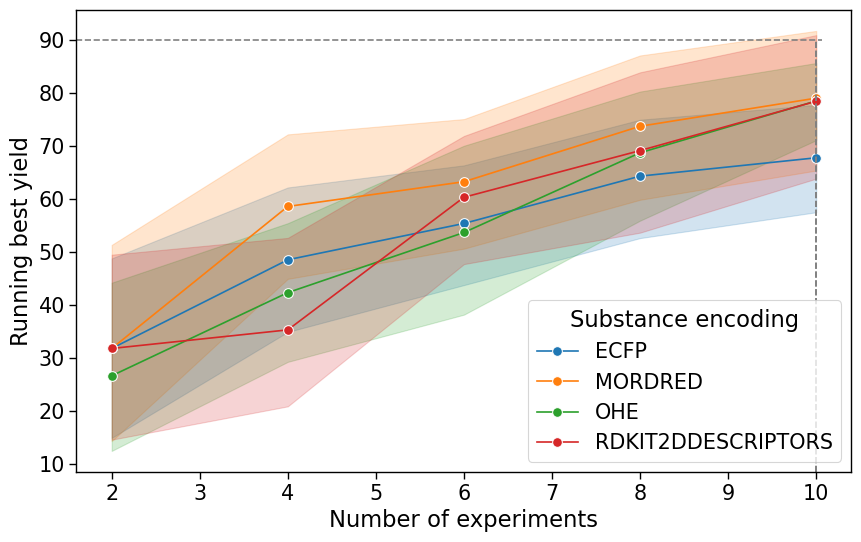

In [ ]:
from utils import backtest_plot

backtest_plot(
    df=results,
    x="Number of experiments",
    y="Running best yield",
    hue="Substance encoding",
    indicator_y=90,
    indicator_labels=["MORDRED", "OHE"],
)